# Hyperparameter tuning and lags selection


Hyperparameter tuning is a crucial aspect of developing accurate and effective machine learning models. In machine learning, hyperparameters are values that cannot be learned from data and must be set by the user before the model is trained. These hyperparameters can significantly impact the performance of the model, and tuning them carefully can improve its accuracy and generalization to new data. In the case of forecasting models, the lags included in the model can be considered as an additional hyperparameter.

Hyperparameter tuning involves systematically testing different values or combinations of hyperparameters (including lags) to find the optimal configuration that produces the best results. The skforecast library offers various hyperparameter tuning strategies, including grid search, random search, and Bayesian search, that can be combined with [backtesting](https://skforecast.org/latest/user_guides/backtesting.html) to identify the optimal combination of lags and hyperparameters that achieve the best prediction performance.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">
<p class="title">
    <i class="fa-solid fa-fire-flame-curved" style="font-size: 18px; color:#00bfa5;"></i>
    <b> &nbsp Tip</b>
</p>

The computational cost of hyperparameter tuning depends heavily on the backtesting approach chosen to evaluate each hyperparameter combination. In general, the duration of the tuning process increases with the number of re-trains involved in the backtesting.

To effectively speed up the prototyping phase, it is highly recommended to adopt a two-step strategy. First, use <code>refit=False</code> during the initial search to narrow down the range of values. Then, focus on the identified region of interest and apply a tailored backtesting strategy that meets the specific requirements of the use case. For additional tips on backtesting strategies, refer to the following resource: <a href="https://skforecast.org/latest/user_guides/backtesting.html#which-strategy-should-i-use">Which backtesting strategy should I use?</a>.

</div>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

Since <b>skforecast 0.9.0</b>, all backtesting and grid search functions have been extended to include the <code>n_jobs</code> argument, allowing multi-process parallelization for improved performance. This applies to all functions of the different <code>model_selection</code> modules. The benefits of parallelization depend on several factors, including the regressor used, the number of fits to be performed, and the volume of data involved. When the <code>n_jobs</code> parameter is set to <code>'auto'</code>, the level of parallelization is automatically selected based on heuristic rules that aim to choose the best option for each scenario.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from sklearn.metrics import mean_squared_error

## Data

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00 (n=29)


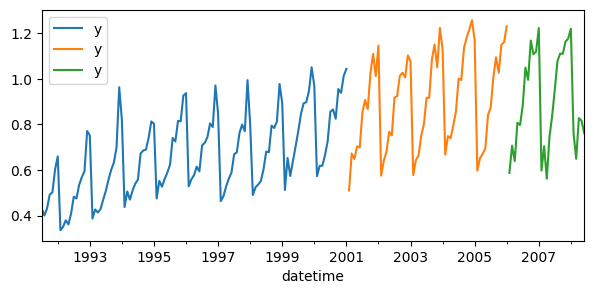

In [2]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f" (n={len(data.loc[end_val:])})"
)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

## Grid search

Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the Skforecast library, two grids are needed: one with different lags (`lags_grid`) and another with the hyperparameters (`param_grid`).

The grid search process involves the following steps:

1. `grid_search_forecaster` creates a copy of the forecaster object and replaces the `lags` argument with the first option appearing in `lags_grid`.

2. The function validates all combinations of hyperparameters presented in `param_grid` using [backtesting](https://skforecast.org/latest/user_guides/backtesting.html).

3. The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

4. If `return_best = True`, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

In [3]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 15, 'n_estimators': 50}
  Backtesting metric: 0.015325449516605583



In [4]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.015325,15,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.019538,5,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.021915,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.023351,15,100
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.024818,10,100
5,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.028400,15,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.029157,5,50
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.030666,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.030762,15,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.030913,5,100


Since `return_best = True`, the forecaster object is updated with the best configuration found and trained with the whole data set. This means that the final model obtained from grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

In [5]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=15, n_estimators=50, random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-07-10 08:27:10 
Last fit date: 2023-07-10 08:27:17 
Skforecast version: 0.9.0 
Python version: 3.11.4 


## Random search

Random search is another hyperparameter tuning strategy available in the Skforecast library. In contrast to grid search, which tries out all possible combinations of hyperparameters and lags, randomized search samples a fixed number of values from the specified possibilities. The number of combinations that are evaluated is given by `n_iter`.

It is important to note that random sampling is only applied to the model hyperparameters, but not to the lags. All lags specified by the user are evaluated.

In [6]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
    'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)
}

results = random_search_forecaster(
              forecaster           = forecaster,
              y                    = data.loc[:end_val, 'y'],
              steps                = 12,
              lags_grid            = lags_grid,
              param_distributions  = param_distributions,
              n_iter               = 5,
              metric               = 'mean_squared_error',
              refit                = False,
              initial_train_size   = len(data.loc[:end_train]),
              fixed_train_size     = False,
              return_best          = True,
              random_state         = 123,
              n_jobs               = 'auto',
              verbose              = False,
              show_progress        = True
          )

results_grid.head(4)

Number of models compared: 10.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 96, 'max_depth': 19}
  Backtesting metric: 0.027234146319364036



,lags,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.015325,15,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.019538,5,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.021915,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.023351,15,100


## Bayesian search

Grid and random search can generate good results, especially when the search range is narrowed down. However, neither of them takes into account the results obtained so far, which prevents them from focusing the search on the regions of greatest interest while avoiding unnecessary ones.

An alternative is to use Bayesian optimization methods to search for hyperparameters. In general terms, bayesian hyperparameter optimization consists of creating a probabilistic model in which the objective function is the model validation metric (RMSE, AUC, accuracy...). With this strategy, the search is redirected at each iteration to the regions of greatest interest. The ultimate goal is to reduce the number of hyperparameter combinations with which the model is evaluated, choosing only the best candidates. This approach is particularly advantageous when the search space is very large or the model evaluation is very slow.

Skforecast offers two Bayesian optimization engines: [Scikit-Optimize](https://scikit-optimize.github.io/stable/) and [Optuna](https://optuna.org/). It is worth noting that, in the context of skforecast, bayesian search is only applied to the hyperparameters of the model, and not to the lags, as all lags specified by the user are evaluated.

### Optuna

In skforecast, Bayesian optimization with Optuna is performed using its [Study object](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study). The objective of the optimization is to minimize the metric generated by backtesting.

Additional parameters can be included by passing a dictionary to `kwargs_create_study` and `kwargs_study_optimize` arguments to [create_study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html) and [optimize method](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize), respectively. These arguments are used to configure the study object and optimization algorithm.

To use Optuna in skforecast, the `search_space` argument must be a python function that defines the hyperparameters to optimize over. Optuna uses the [Trial object](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial) object to generate each search space.

In [7]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'     : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    } 
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = data.loc[:end_val, 'y'],
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = False,
                            initial_train_size    = len(data.loc[:end_train]),
                            fixed_train_size      = True,
                            n_trials              = 10,
                            random_state          = 123,
                            return_best           = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                        )

results_grid.head(4)

Number of models compared: 20,
         10 bayesian search in each lag configuration.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

,lags,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.015325,15,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.019538,5,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.021915,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.023351,15,100


`frozen_trial` contains information of the trial which achived the best results: See more in [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [8]:
frozen_trial

FrozenTrial(number=3, state=1, values=[0.13263306663095237], datetime_start=datetime.datetime(2023, 7, 10, 8, 27, 22, 66756), datetime_complete=datetime.datetime(2023, 7, 10, 8, 27, 22, 152335), params={'n_estimators': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

### Scikit-optimize

Skopt performs bayesian optimization with Gaussian processes. This is done with the function [gp_minimize](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize) where the objective value to be minimized is calculated by [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html).

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

This engine is deprecated since skforecast 0.7.0 in favor of optuna engine. To continue using it, install skforecast 0.6.0.
<br><br>
User guide: https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/hyperparameter-tuning-and-lags-selection.html#scikit-optimize

</div>

## Hyperparameter tuning with custom metric

Besides to the commonly used metrics such as `mean_squared_error`, `mean_absolute_error`, and `mean_absolute_percentage_error`, users have the flexibility to define their own custom metric function, provided that it includes the arguments `y_true` (the true values of the series) and `y_pred` (the predicted values), and returns a numeric value (either a `float` or an `int`).

This customizability enables users to evaluate the model's predictive performance in a wide range of scenarios, such as considering only certain months, days, non holiday; or focusing only on the last step of the predicted horizon.

To illustrate this, consider the following example: a 12-month horizon is forecasted, but the interest metric is calculated by considering only the last three months of each year. This is achieved by defining a custom metric function that takes into account only the relevant months, which is then passed as an argument to the backtesting function.

The example below demonstrates how to use hyperparameter optimization to find the optimal parameters for a custom metric that considers only the last three months of each year. 

In [9]:
# Custom metric
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_squared_error(y_true[mask], y_pred[mask])
    
    return metric

In [10]:
# Grid search hyperparameter and lags with custom metric
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val, 'y'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 12,
                   refit              = False,
                   metric             = custom_metric,
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(4)

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 15, 'n_estimators': 100}
  Backtesting metric: 0.030341102602751614



,lags,params,custom_metric,max_depth,n_estimators
5,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.030341,15,100
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.032391,15,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.034509,5,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.038321,10,50


## Compare multiple metrics

All three functions (`grid_search_forecaster`, `random_search_forecaster`, and `bayesian_search_forecaster`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list may include custom metrics and the best model selection is done based on the first metric of the list.


All three functions (`grid_search_forecaster`, `random_search_forecaster`, and `bayesian_search_forecaster`) enable users to calculate multiple metrics for each forecaster configuration if a list is provided. This list may include any combination of built-in metrics, such as `mean_squared_error`, `mean_absolute_error`, and `mean_absolute_percentage_error`, as well as user-defined custom metrics.

Note that if multiple metrics are specified, these functions will select the best model based on the **first metric in the list**.

In [11]:
# Grid search hyperparameter and lags with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 10 # Placeholder, the value will be overwritten
             )

# Metrics
metrics = ['mean_absolute_error', mean_squared_error, custom_metric]

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data.loc[:end_val, 'y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 12,
                    refit              = False,
                    metric             = metrics,
                    initial_train_size = len(data.loc[:end_train]),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False,
                    show_progress      = True
               )

results_grid.head(4)

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 15, 'n_estimators': 50}
  Backtesting metric: 0.09876770647333354



,lags,params,mean_absolute_error,mean_squared_error,custom_metric,max_depth,n_estimators
4,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.098768,0.015325,0.032391,15,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.108105,0.019538,0.034509,5,50
3,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.115013,0.024818,0.038799,10,100
5,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.115177,0.028400,0.030341,15,100


## Compare multiple regressors

The grid search process can be easily extended to compare several machine learning models. This can be achieved by using a simple for loop that iterates over each regressor and applying the `grid_search_forecaster` function. This approach allows for a more thorough exploration and can help you select the best model.

In [12]:
# Models to compare
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

models = [RandomForestRegressor(random_state=123), 
          GradientBoostingRegressor(random_state=123),
          Ridge(random_state=123)]

# Hyperparameter to search for each model
param_grids = {'RandomForestRegressor': {'n_estimators': [50, 100], 'max_depth': [5, 15]},
               'GradientBoostingRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10]},
               'Ridge': {'alpha': [0.01, 0.1, 1]}}

# Lags used as predictors
lags_grid = [3, 5]

df_results = pd.DataFrame()
for i, model in enumerate(models):

    print(f"Grid search for regressor: {model}")
    print(f"-------------------------")

    forecaster = ForecasterAutoreg(
                     regressor = model,
                     lags      = 3
                 )

    # Regressor hyperparameters
    param_grid = param_grids[list(param_grids)[i]]

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, 'y'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 3,
                       refit              = False,
                       metric             = 'mean_squared_error',
                       initial_train_size = len(data.loc[:end_train]),
                       fixed_train_size   = True,
                       return_best        = False,
                       n_jobs             = 'auto',
                       verbose            = False,
                       show_progress      = True
                   )
    
    # Create a column with model name
    results_grid['model'] = list(param_grids)[i]
    
    df_results = pd.concat([df_results, results_grid])

df_results = df_results.sort_values(by='mean_squared_error')
df_results.head(10)

Grid search for regressor: RandomForestRegressor(random_state=123)
-------------------------
Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Grid search for regressor: GradientBoostingRegressor(random_state=123)
-------------------------
Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Grid search for regressor: Ridge(random_state=123)
-------------------------
Number of models compared: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

,lags,params,mean_squared_error,max_depth,n_estimators,model,alpha
0,"[1, 2, 3]",{'alpha': 0.01},0.059814,NaN,NaN,Ridge,0.01
1,"[1, 2, 3]",{'alpha': 0.1},0.060078,NaN,NaN,Ridge,0.10
3,"[1, 2, 3, 4, 5]",{'alpha': 0.01},0.061481,NaN,NaN,Ridge,0.01
4,"[1, 2, 3, 4, 5]",{'alpha': 0.1},0.061765,NaN,NaN,Ridge,0.10
2,"[1, 2, 3]",{'alpha': 1},0.063084,NaN,NaN,Ridge,1.00
5,"[1, 2, 3, 4, 5]",{'alpha': 1},0.064954,NaN,NaN,Ridge,1.00
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.076140,5.0,100.0,RandomForestRegressor,NaN
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.078051,5.0,50.0,RandomForestRegressor,NaN
3,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.081714,15.0,100.0,RandomForestRegressor,NaN
2,"[1, 2, 3]","{'max_depth': 15, 'n_estimators': 50}",0.082889,15.0,50.0,RandomForestRegressor,NaN


In [13]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>